### Steps to be executed:

1) Fazer uma lista de arquivos com URL das seguintes imagens:
 - Teddy bear
 - Black Bear
 - Grizzly

Usar o Google Images com o seguinte comando:

> Cmd Opt J

> urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContext).ou);

> window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

Esses comandos irão fazer o downloado das imagens em um arquivo CSV.

2) Usando Tensorflow, crie um dataset com esses caminhos e uma função de transformação para fazer o download dessa imagem e depois redimensionar.

Crie também os labels para cada imagem. Se usar o ImageGenerator, já fazer o split para treinamento, validação e teste.

Garantir que sempre teremos o mesmo Validation Set. Isso é importante para sempre termos o mesmo conjunto de validação e determinar se mudanças no modelo afetam a qualidade na validação. 

3) Limpar o Dataset para possíveis imagens corrompidas ou arquivos que não são imagens.

4) Análise do Dataset
 - Mostra quantos exemplos existe para cada dataset
 - Plota alguns exemplos para termos base de comparação

Neste ponto já temos o Dataset de treinamento e Validação criados e prontos para serem treinados.

5) Model Creation: Importar o ResNet50V2 com weights do ImageNet.
 - Compilar com o Optimizer, Loss corretos.
 - Criar uma função de Callback para analisar dinamicamente o Learning Rate.
  - Rodar o FIT por 10 epochs e chegar no melhor LR.
 - Treinar com FIT no melhor epoch.

6) Plotar qual foi a performance de treinamento. SAVE and LOAD models.
 - Salvar o modelo de duas maneiras (arquivo H5 e checkpoint). Qual a vantagem de usar um ou outro? Qual eu posso recuperar tanto a arquitetura quanto weights? Como eu posso continuar treinando?

7) Determinar quantas camadas (layers) existem na rede. Fazer UNFREEZE das camadas e refazer o treinamento agora com mais weights em jogo.

8) Usar alguns exemplos com PREDICT para ver se realmente está correto o modelo.
 - Plotar uma confusion_matrix.
 - Pelo Confusion Matrix, determinar se determinada imagem é "noisy" ou não.
 - Determinar os "top losses".
 - Deletar os exemplos no dataset de Treino e Validação.

9) Assim como no MOOC, criar um backpropagation usando GradientTapes (PyTorch é MUITO mais fácil)

# Questões sobre Tensorflow

1) Quais operações podemos fazer com Tensors? Existe a operação de index, element access, dimensions, etc.?
 - Explorar ao máximo o que são esses conceitos no Tensorflow.
 - Como faço operações de alteração no Tensor? Substituição implace? Ou retorno?

2) Como calcular o LOSS function no Tensorflow? Quais funções de LOSS estão disponíveis?

# Tensorflow Version of Lesson 2

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
# Import Tensorflow
import tensorflow as tf

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Other imports
import numpy as np
import matplotlib.pyplot as plt

import os
import pandas as pd

import pathlib

In [ ]:
# URLs for download
black = 'https://drive.google.com/uc?id=1ampU2pBFu1iZYA-F8XsxH1R4EvICZYFZ'
grizzly = 'https://drive.google.com/uc?id=1nye6A_2t9Y1aBkWoHh8XN3NhW5hZ3Sq2'
teddy = 'https://drive.google.com/uc?id=1WklQaY76VeO-NH_pO8EJ18vkRvBEglJF'

In [ ]:
classes = ['black','grizzly', 'teddy']
parent_dir = '/content'

In [ ]:
# Get csv files with URLs to download
!wget https://drive.google.com/uc?id=1ampU2pBFu1iZYA-F8XsxH1R4EvICZYFZ -O black.csv
!wget https://drive.google.com/uc?id=1nye6A_2t9Y1aBkWoHh8XN3NhW5hZ3Sq2 -O grizzly.csv
!wget https://drive.google.com/uc?id=1WklQaY76VeO-NH_pO8EJ18vkRvBEglJF -O teddy.csv

In [ ]:
# Create folders and save paths
paths = {}

for i in range(len(classes)):
    paths[classes[i]] = os.path.join(parent_dir, classes[i])
    os.mkdir(paths[classes[i]])

In [ ]:
df_black = pd.read_csv('/content/black.csv', index_col=None, header=None)
df_grizzly = pd.read_csv('/content/grizzly.csv', index_col=None, header=None)
df_teddy = pd.read_csv('/content/teddy.csv', index_col=None, header=None)

In [ ]:
# Download Black Bear images
for i in range(len(df_black[0])):
    fname = paths['black'] + '/black_' + str(i) + '.jpg';
    tf.keras.utils.get_file(fname = fname, origin=df_black[0][i]);

In [ ]:
# Download Grizzly Bear images
for i in range(len(df_grizzly[0])):
    fname = paths['grizzly'] + '/grizzly_' + str(i) + '.jpg';
    tf.keras.utils.get_file(fname = fname, origin=df_grizzly[0][i]);

In [ ]:
# Download Teddy Bear images
for i in range(len(df_teddy[0])):
    fname = paths['teddy'] + '/teddy_' + str(i) + '.jpg';
    tf.keras.utils.get_file(fname = fname, origin=df_teddy[0][i]);

In [ ]:
os.mkdir('/content/images')

In [ ]:
!mv -v /content/black/ /content/images/
!mv -v /content/grizzly/ /content/images/
!mv -v /content/teddy/ /content/images/

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CLASS_NAMES = ['grizzly', 'black', 'teddy']

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[list(label_batch[n] == 1).index(1)])
      plt.axis('off')

In [ ]:
data_dir = pathlib.Path('/content/images')

In [ ]:
# Get list with file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
# Function to get label
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [ ]:
# Function to decode Image
def decode_image(img):
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [ ]:
# Function to use in MAP Dataset
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_image(img)

    return img, label

In [ ]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
    print(image.numpy().shape)
    print(label.numpy())

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
# Split for Training and Validation
train_split = train_ds.skip(100)
test_split = train_ds.take(100)

In [ ]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [ ]:
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 5))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
history = model.fit(train_split, epochs=1, validation_data=test_split, 
                    steps_per_epoch=26, callbacks=callbacks)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir './logs'

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
!rm -rf logs

In [ ]:
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

In [ ]:
logdir = 'logs/train_data/' + datetime.now().strftime("%Y%m%d-%H%M%S")

file_writer = tf.summary.create_file_writer(logdir)
with file_writer.as_default():
    tf.summary.image('Training data', renato, step=0)

In [ ]:
renato = 0
for i in train_split.take(1):
    renato = i

In [ ]:
renato = np.reshape(renato[0].numpy()[0], (-1,224,224,3))

In [ ]:
# Clear out any prior log data.
!rm -rf logs

In [ ]:
%tensorboard --logdir './logs'

In [ ]:
for layer in base_model.layers[:40]:
    layer.trainable = False

In [ ]:
len(model.trainable_variables)

In [ ]:
model.summary()

In [ ]:
len(base_model.layers) + len(model.layers) -1

In [ ]:
checkpoint_path = 'ckp/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose = 1)

In [ ]:
model.fit(train_split, epochs=3, validation_data=test_split,
          callbacks=[cp_callback], steps_per_epoch=26)

In [ ]:
model_renato = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model_renato.load_weights(checkpoint_path)

### Saving the model

1) Checkpoint using Callback.ModelCheckPoint
 - This way we can save the model weights. We must provide the model architecture (same as saved check point) to continue training or making predictions.

2) Manually Save Weights
 - model.save_weights(path)
 - model.load_weights(path)
  - The assumptions remains the same as before.

3) Salva TUDO em um arquivo HDF5
 - Salta tudo, architetura do modelo, weights, configurations for optimizers.
 - model.save(path.h5)
 - Use: tf.keras.models.load_model(path.h5)

Note that when we specify the extension of the file (h5), we force the keras to save the entire model.

4) SavedModel
 - We just don't specify the extension h5 to the model. Just pass a directory and it will use the SavedModel format.
 - 

In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('saved_model/my_model')

In [ ]:
tf.saved_model.save(model, 'saved_model/resnet50/1/')

In [ ]:
img = tf.keras.utils.get_file('/content/img_test.jpg', 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.buildabear.com%2Fred-paw-timeless-teddy%2F026433.html&psig=AOvVaw24F0SqxqXjAS76kT8pRN2R&ust=1581038953305000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCODclJzju-cCFQAAAAAdAAAAABAD')

In [ ]:
type(img)

In [ ]:
!wget https://drive.google.com/uc?id=19NduSROyZjeiyCNNzvpeWV9ShKZ-x6xH -O teddy.jpg

In [ ]:
img = tf.io.read_file('/content/teddy.jpg')

In [ ]:
type(img)

In [ ]:
img = tf.io.decode_jpeg(img, 3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (224,224))

In [ ]:
img = tf.expand_dims(img, 0)

In [ ]:
CLASS_NAMES[np.argmax(model.predict(img))]

In [ ]:
type(img)

In [ ]:
teste = tf.Variable([[[1,2,3]]], tf.int8)

In [ ]:
type(teste)

In [ ]:
tf.rank(teste)

In [ ]:
tf.executing_eagerly()

# Custom Training

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Using Numpy Arrays
# Mean Squared Error
def loss(yhat, y):
    return tf.reduce_mean(tf.square(yhat - y))

In [ ]:
n=10

In [ ]:
x = tf.concat([tf.random.uniform([n,1],-1,1), tf.ones([n,1])], 1)
a = tf.Variable([[3.],[2.]])

In [ ]:
# Segunda tentativa com 1 parâmetro de a
x = tf.random.uniform([n,1],-1,1)
a = tf.Variable([[3.]])

In [ ]:
print(x)

tf.Tensor(
[[ 0.74772644]
 [-0.72707963]
 [ 0.8555572 ]
 [-0.69729614]
 [ 0.462775  ]
 [ 0.8218348 ]
 [-0.37364578]
 [ 0.37313485]
 [ 0.6379788 ]
 [-0.06178117]], shape=(10, 1), dtype=float32)


In [ ]:
print(a)

<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>


In [ ]:
y = tf.add(tf.matmul(x,a), tf.random.uniform([n,1]))

In [ ]:
print(y.shape)
print(y)

(10, 1)
tf.Tensor(
[[-0.5728791 ]
 [ 3.0344272 ]
 [ 2.2656276 ]
 [-2.198361  ]
 [ 0.8416921 ]
 [ 3.906774  ]
 [ 1.2642441 ]
 [-1.2943715 ]
 [ 1.7936494 ]
 [ 0.00989008]], shape=(10, 1), dtype=float32)


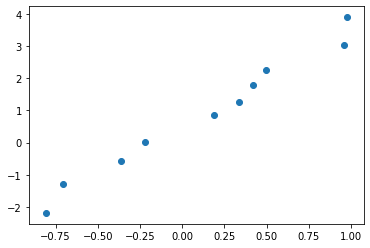

In [ ]:
plt.scatter(x[:,0], y);

In [ ]:
a = tf.Variable([[-1.]])
y_hat = tf.matmul(x,a)

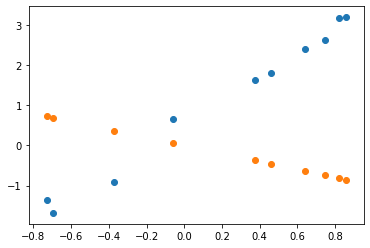

In [ ]:
plt.scatter(x[:,0], y);
plt.scatter(x[:,0], y_hat);

In [ ]:
print(loss(y_hat, y))

tf.Tensor(7.436952, shape=(), dtype=float32)


In [ ]:
x = tf.Variable(y_hat - y)
with tf.GradientTape() as tape:
    l = tf.reduce_mean(tf.square(x))

In [ ]:
grad = tape.gradient(l, x)

In [ ]:
print(grad)

tf.Tensor(
[[-0.6736862 ]
 [ 0.4180568 ]
 [-0.81260127]
 [ 0.47774053]
 [-0.45443687]
 [-0.7981587 ]
 [ 0.25803468]
 [-0.40090972]
 [-0.6097829 ]
 [-0.12199912]], shape=(10, 1), dtype=float32)


In [ ]:
lr = 0.001
a - (lr*grad)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.9993263 ],
       [-1.0004181 ],
       [-0.9991874 ],
       [-1.0004778 ],
       [-0.9995456 ],
       [-0.99920183],
       [-1.0002581 ],
       [-0.9995991 ],
       [-0.99939024],
       [-0.999878  ]], dtype=float32)>

In [ ]:
def mse(yhat, y):
    return tf.reduce_mean(tf.square(yhat - y))

In [ ]:
n=10
epochs = 1
lr = 0.1

x = tf.random.uniform([n,1],-1,1)
a = tf.Variable([[3.]])

y = tf.add(tf.matmul(x,a), tf.random.uniform([n,1]))

a = tf.Variable([[-1.]])

In [ ]:
def update(epochs, lr, x, y, a):
    # Calculate predictions
    y_hat = tf.matmul(x,a)
    
    # Calculate and print Loss
    loss = mse(y_hat, y)
    #if(t%10 == 0): print(loss)

    # Get Loss and Gradients
    w = tf.Variable(y_hat - y)
    with tf.GradientTape() as tape:
        l = tf.reduce_mean(tf.square(w))
    grad = tape.gradient(l, w)

    a = a - tf.reduce_mean(lr*grad)
    return a, loss 

In [ ]:
for i in range(1000):
    a, loss = update(1, 0.1, x, y, a)
print('Novo Valor de a: ', a)
print('Loss: ', loss)

Novo Valor de a:  tf.Tensor([[-42.244186]], shape=(1, 1), dtype=float32)
Loss:  tf.Tensor(663.36163, shape=(), dtype=float32)


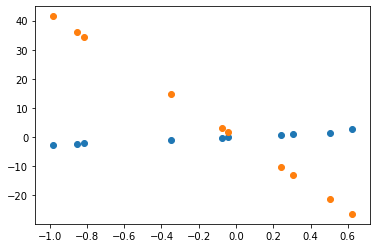

In [ ]:
plt.scatter(x[:,0], y);
plt.scatter(x[:,0], tf.matmul(x,a));